In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_arxiv import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency
from src.train.positional_omega.node2vec import PositionalOmegaNode2Vec

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
dataset_name = 'ogbn-arxiv'

In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/07-1-positional_omega_node2vec_cossim.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test, neg_edges_train =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device, get_neg_edges_train=True)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [7]:
pq_space = np.logspace(-1, 1, 5).round(2)
pq_space

array([ 0.1 ,  0.32,  1.  ,  3.16, 10.  ])

In [8]:
omega = PositionalOmegaNode2Vec(
                device,
                edge_index,
                data.num_nodes,
                1,
                1,
                run=0)

In [9]:
for run in range(5):
    for p in pq_space:
        for q in pq_space:
            omega = PositionalOmegaNode2Vec(
                device,
                edge_index,
                data.num_nodes,
                p,
                q,
                run=run)
            torch.cuda.empty_cache()
            omega.train(edge_index,
                        edges_val,
                        edges_test,
                        neg_edges_train,
                        neg_edges_val,
                        neg_edges_test,
                        edges_train_auc,
                        edges_val_auc,
                        edges_test_auc,
                        data.y)
            omega.discard_run_not_optimal_models()

KeyboardInterrupt: 

## Results

### For a layer number

In [6]:
pq_space = np.logspace(-1, 1, 5).round(2)
param_grid = ParameterGrid({
    'p': pq_space,
    'q': pq_space,
})

In [7]:
chosen_param = param_grid[20]
chosen_param

{'q': 0.1, 'p': 10.0}

In [8]:
metrics = PositionalOmegaNode2Vec.read_metrics(
    dataset='ogbn-arxiv',
    **chosen_param
)
metrics['node2vec_loss'] = metrics['node2vec_loss'].replace('None', np.nan).astype(float)
print(metrics.shape)
metrics.head()

(153, 11)


,p,q,run,epoch,node2vec_loss,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,10.0,0.1,0,0,NaN,1.391800,1.390555,1.390898,0.501822,0.500151,0.500447
1,10.0,0.1,0,10,1.844948,1.302552,1.317694,1.318205,0.531261,0.519956,0.517134
2,10.0,0.1,0,20,1.100557,1.219210,1.239001,1.239450,0.542450,0.522920,0.518409
3,10.0,0.1,0,30,0.947736,1.167681,1.190413,1.190222,0.544134,0.541317,0.539753
4,10.0,0.1,0,40,0.898165,1.132499,1.156622,1.156054,0.560705,0.571115,0.568930


### Sumarize metrics per epoch

In [9]:
metrics_cols = metrics.columns[3:]
metrics_cols

Index(['epoch', 'node2vec_loss', 'loss_train', 'loss_val', 'loss_test',
       'auc_train', 'auc_val', 'auc_test'],
      dtype='object')

In [10]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [11]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,epoch_mean,epoch_std,node2vec_loss_mean,node2vec_loss_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,,,
0,0.0,0.0,-1.000000,0.000000,1.391984,0.000402,1.391597,0.001130,1.390793,0.000769,0.500873,0.001448,0.499798,0.000714,0.500018,0.000586
10,10.0,0.0,1.845358,0.000429,1.303511,0.000850,1.319246,0.001355,1.318877,0.000816,0.530054,0.001812,0.519795,0.002589,0.515510,0.002548
20,20.0,0.0,1.099777,0.001157,1.219582,0.000335,1.239906,0.000884,1.239425,0.000024,0.539490,0.002609,0.522728,0.000430,0.517460,0.000860
30,30.0,0.0,0.946869,0.000840,1.168047,0.000328,1.191216,0.000803,1.189972,0.000307,0.540453,0.003487,0.539540,0.001749,0.536923,0.002470
40,40.0,0.0,0.898080,0.000078,1.132698,0.000198,1.157271,0.000680,1.155730,0.000282,0.557659,0.002979,0.568213,0.002518,0.565348,0.003103


In [12]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,epoch_mean,epoch_std,node2vec_loss_mean,node2vec_loss_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,,,
90,90.0,0.0,0.856155,0.000198,1.090941,0.000516,1.115450,0.000524,1.114691,0.000668,0.608575,0.000810,0.621361,0.000569,0.620549,0.000559
80,80.0,0.0,0.858177,0.000423,1.091018,0.000496,1.116151,0.000112,1.114982,0.000661,0.607192,0.001092,0.621334,0.000560,0.619859,0.000803
100,100.0,0.0,0.854397,0.000087,1.091699,0.000747,1.116782,0.000369,1.115740,0.000723,0.608949,0.001224,0.621281,0.000279,0.619408,0.000830
110,110.0,0.0,0.853570,0.000295,1.093174,0.000964,1.117846,0.000264,1.117587,0.000689,0.608555,0.000028,0.619595,0.000590,0.617875,0.000187
120,120.0,0.0,0.853034,0.000077,1.094609,0.000573,1.119255,0.000232,1.118824,0.000344,0.607580,0.000326,0.618295,0.000256,0.616814,0.000115


/tmp/ipykernel_42618/1600198588.py:10: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_42618/1600198588.py:11: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_42618/1600198588.py:37: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behav

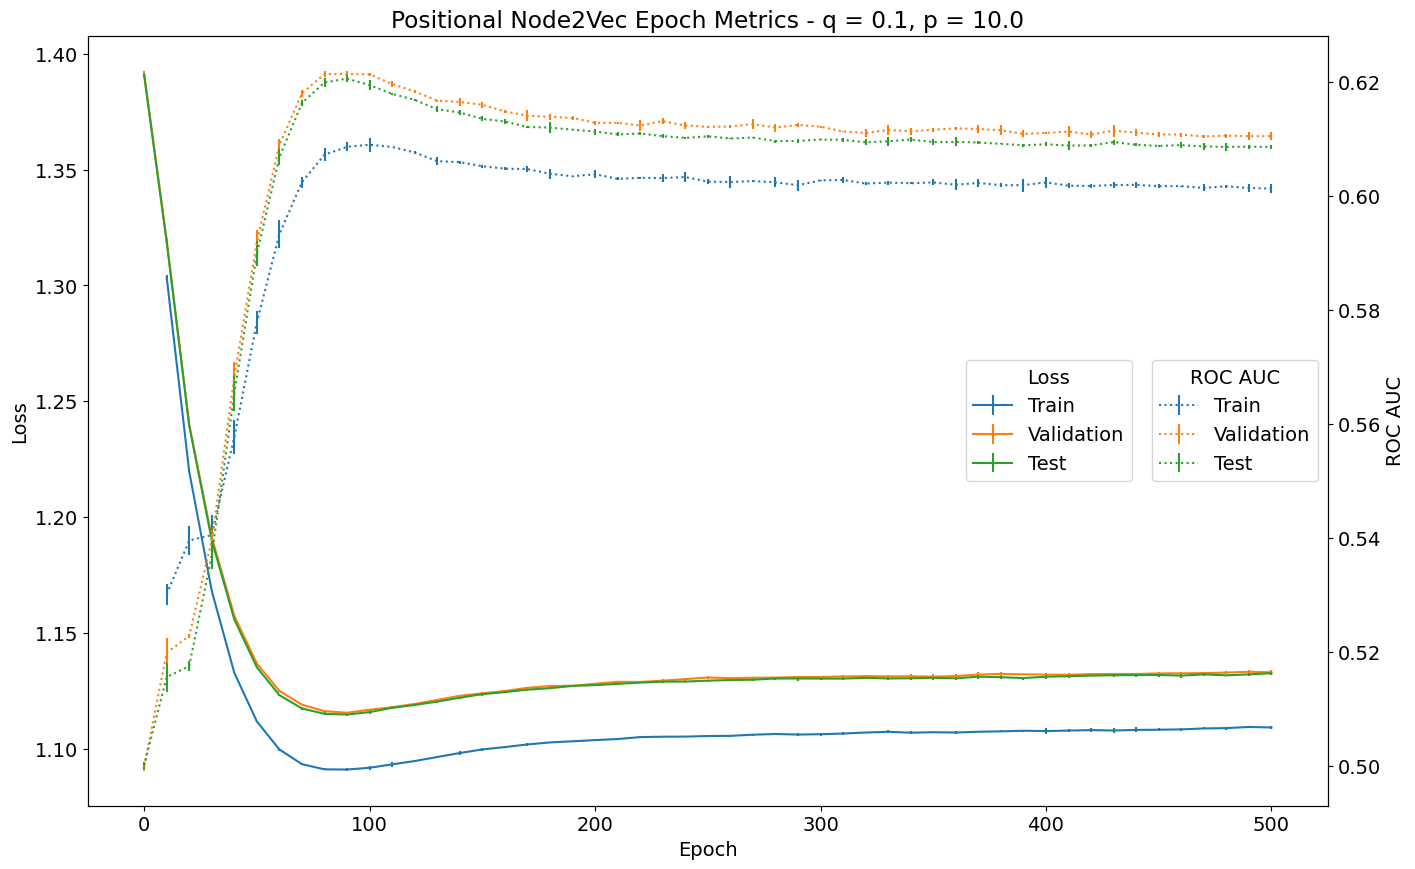

In [13]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

str_desc = ', '.join([f'{k} = {v}' for k, v in chosen_param.items()])

ax1.set_title(f'Positional Node2Vec Epoch Metrics - {str_desc}')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')


str_path_desc = '__'.join([f'{k}_{v}' for k, v in chosen_param.items()])
plt.savefig(f'reports/images/positional_omega_node2vec_{str_path_desc}_cossim_training_metrics.pdf')

### Comparing Validation Performance for All Layer numbers

In [14]:
n_layers_list = range(1, 4)

In [15]:
tuple(param_grid[20].items())

(('q', 0.1), ('p', 10.0))

In [16]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}

full_metrics_list = []
for params in param_grid:
    param_tuple = tuple(params.items())
    metrics = PositionalOmegaNode2Vec.read_metrics(
        dataset='ogbn-arxiv',
        **params
    )
    full_metrics_list.append(metrics)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    max_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[param_tuple] = auc_val
    mean_loss_val_dict[param_tuple] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[param_tuple] = auc_val
    std_loss_val_dict[param_tuple] = loss_val

full_metrics_df = pd.concat(full_metrics_list)

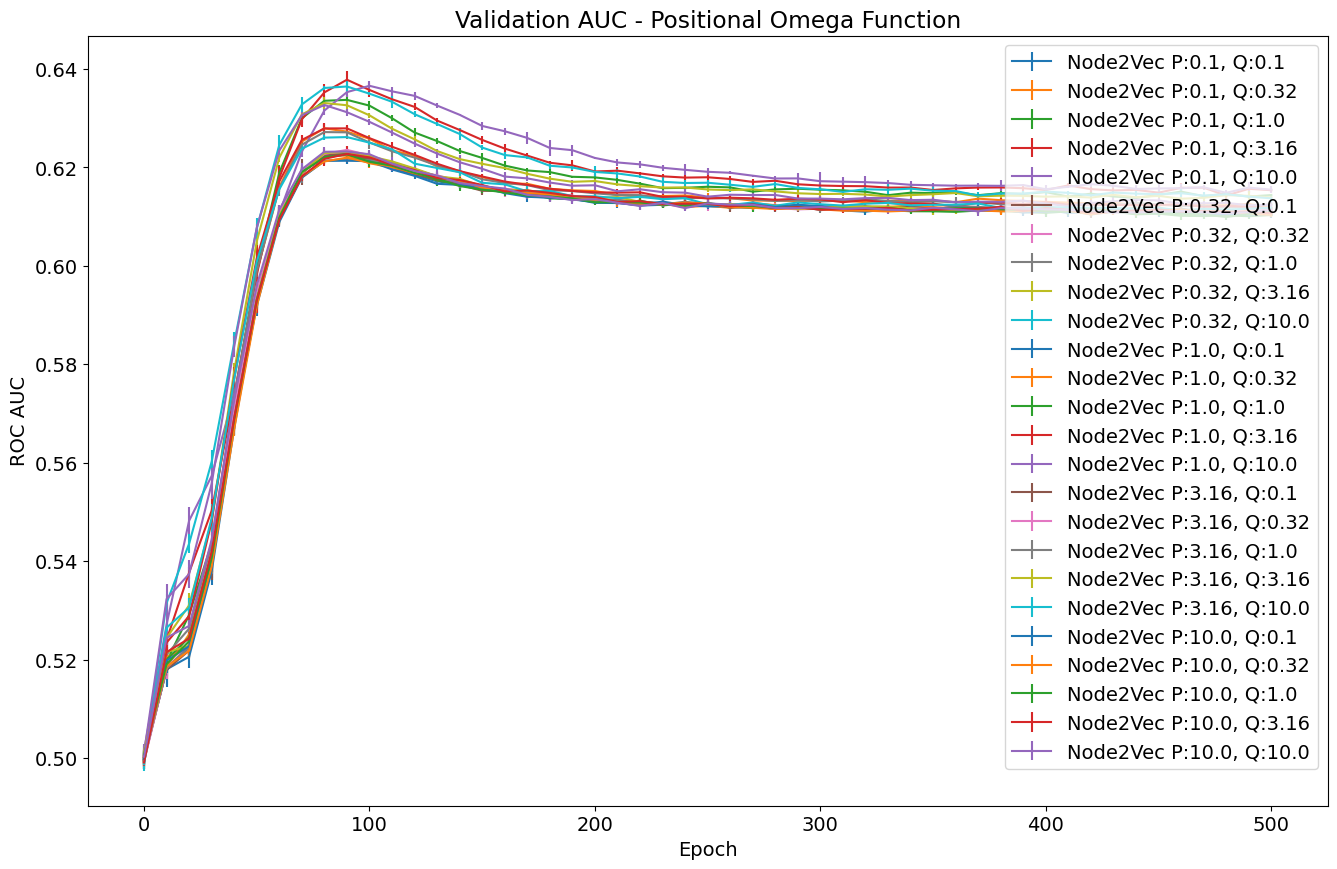

In [17]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Positional Omega Function')

for params in param_grid:
    param_tuple = tuple(params.items())
    ax1.errorbar(
        mean_auc_val_dict[param_tuple].index,
        mean_auc_val_dict[param_tuple],
        yerr=std_auc_val_dict[param_tuple],
        ls='-',
        label=f'Node2Vec P:{params["p"]}, Q:{params["q"]}')


# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

### Best AUC Heatmap

<AxesSubplot: xlabel='q', ylabel='p'>

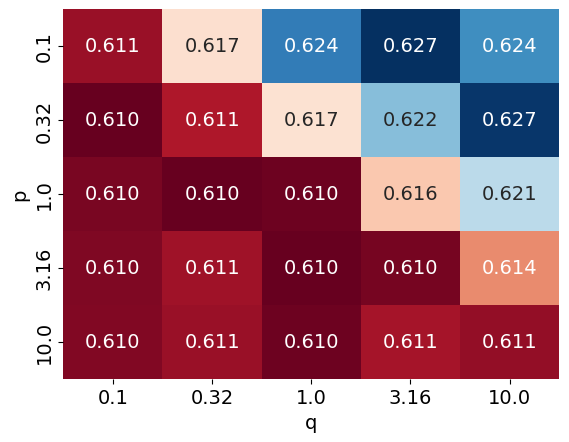

In [18]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_train'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

<AxesSubplot: xlabel='q', ylabel='p'>

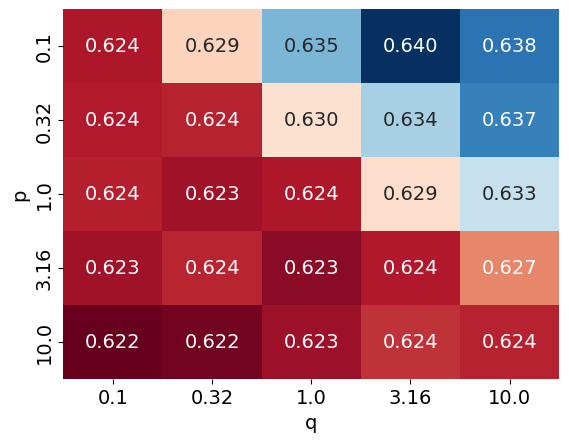

In [19]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_val'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

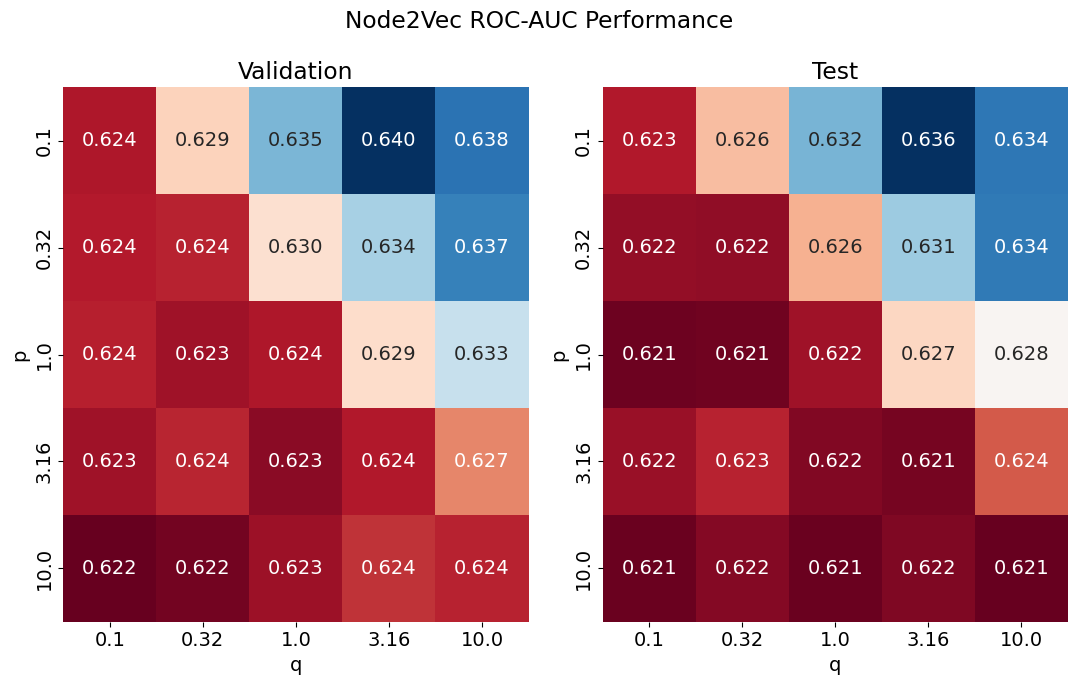

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7))

fig.suptitle('Node2Vec ROC-AUC Performance')

sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_val'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax1
)

ax1.set_title('Validation')


sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_test'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax2,
)

ax2.set_title('Test')

plt.tight_layout()

plt.savefig(f'reports/images/positional_omega_node2vec_rocauc_summary.pdf')

## Score Best model

In [21]:
best_model_metrics = full_metrics_df.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

p                               0.1
q                              3.16
run                               2
epoch                            90
node2vec_loss    0.8047587275505066
loss_train                 1.092583
loss_val                   1.126565
loss_test                   1.12575
auc_train                  0.622313
auc_val                    0.640109
auc_test                   0.635919
Name: 111, dtype: object

In [23]:
best_model_metrics.to_json('models/positional_omega_node2vec/best_model_info.json')

### Load data

In [24]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

### Load model

In [25]:
data.num_nodes

169343

In [82]:
omega = PositionalOmegaNode2Vec.load_model(
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    dataset='ogbn-arxiv',
    edge_index=edge_index,
    num_nodes=data.num_nodes,
    p=best_model_metrics['p'],
    q=best_model_metrics['q'],
)

In [83]:
best_model_metrics

p                               0.1
q                              3.16
run                               2
epoch                            90
node2vec_loss    0.8047587275505066
loss_train                 1.092583
loss_val                   1.126565
loss_test                   1.12575
auc_train                  0.622313
auc_val                    0.640109
auc_test                   0.635919
Name: 111, dtype: object

### Score model

In [84]:
dataset = load_dataset()
data = prepare_adjencency(dataset[0], to_symmetric=True).to(device)

edge_index = get_edge_index_from_adjencency(data, device)

In [85]:
preds = omega.forward(edge_index).to('cpu').detach().numpy()
preds[:5]

array([[0.67033464],
       [0.7052192 ],
       [0.7021323 ],
       [0.70877177],
       [0.7010413 ]], dtype=float32)

In [86]:
preds_test = omega.forward(edges_test_auc).to('cpu').detach().numpy()
preds_test

array([[0.69034636],
       [0.6741897 ],
       [0.64102775],
       ...,
       [0.6863525 ],
       [0.69423336],
       [0.68168193]], dtype=float32)

In [91]:
theta = omega.is_same_class(edge_index, data.y).to('cpu').detach().numpy()

In [92]:
roc_auc_score(theta, preds)

0.6333412018181015

In [93]:
theta.mean()

0.6542197738985782

### Save output

In [94]:
cpu_edges = edge_index.to('cpu').numpy()
edges_omega_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'omega_pred': preds[:,0]
})
print(edges_omega_df.shape)
edges_omega_df.head()

(2315598, 3)


,source,target,omega_pred
0,411,0,0.670335
1,640,0,0.705219
2,1162,0,0.702132
3,1897,0,0.708772
4,3396,0,0.701041


In [96]:
edges_omega_df.to_csv(f'data/scored_omega/{dataset_name}/positional_node2vec.csv', index=False)

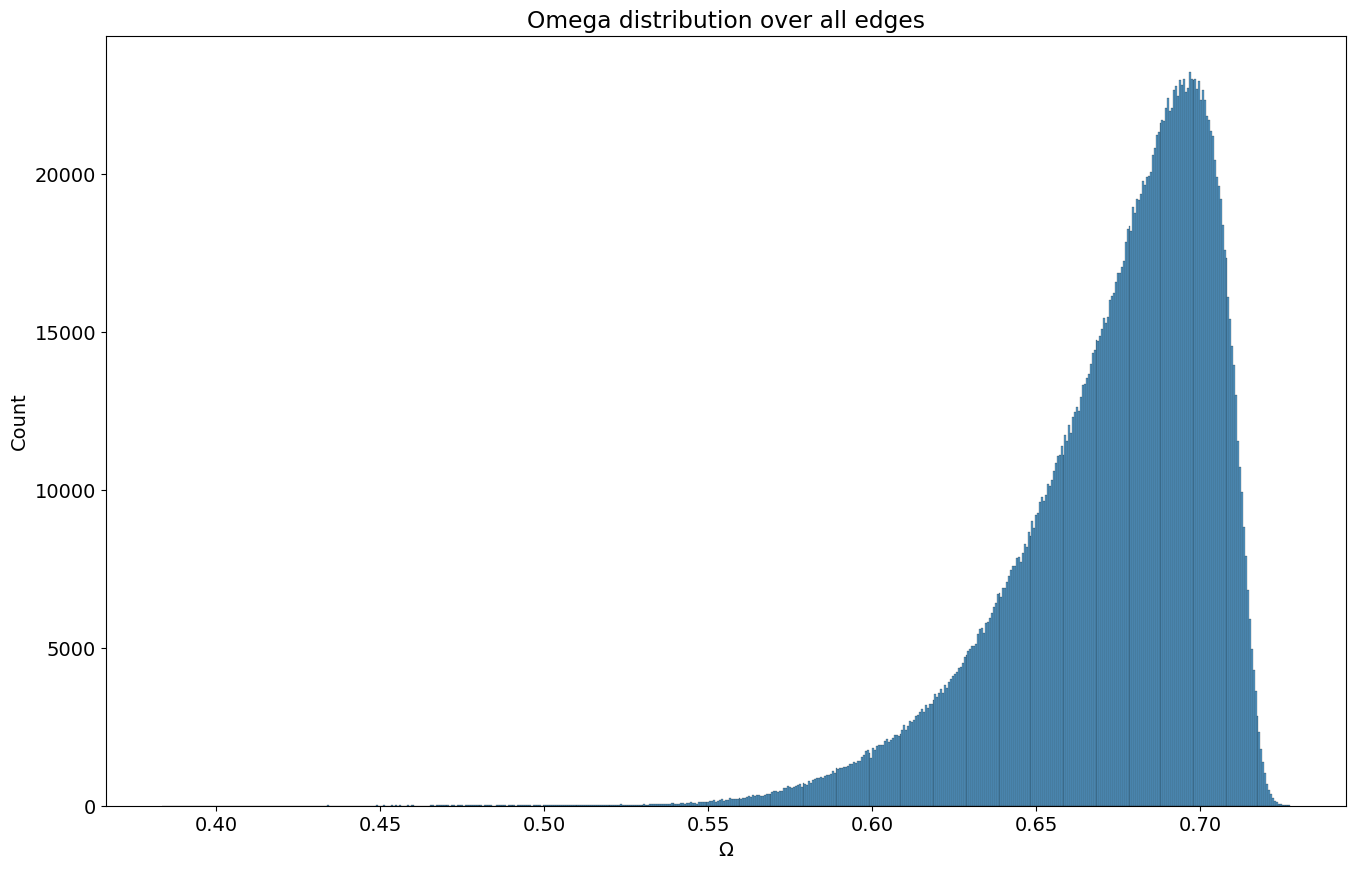

In [99]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_omega_df['omega_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig(f'reports/images/{dataset_name}/positional_node2vec/best_omega_distribution.png')

In [100]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_omega_df['omega_pred'].mean()],
    'Std. Dev.': [edges_omega_df['omega_pred'].std()],
    'Skewness': [edges_omega_df['omega_pred'].skew()],
    'Kurtosis': [edges_omega_df['omega_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.633000 & 0.674000 & 0.030000 & -1.199000 & 1.937000 \\
\end{tabular}



In [ ]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_omega_df['omega_pred'].mean()],
    'Std. Dev.': [edges_omega_df['omega_pred'].std()],
    'Skewness': [edges_omega_df['omega_pred'].skew()],
    'Kurtosis': [edges_omega_df['omega_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.683000 & 0.716000 & 0.054000 & -4.401000 & 23.403000 \\
\end{tabular}

